c:\Users\Daniel Klaaby\micromamba\envs\sam_lang\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
c:\Users\Daniel Klaaby\micromamba\envs\sam_lang\lib\site-packages\transformers\utils\generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(
c:\Users\Daniel Klaaby\micromamba\envs\sam_lang\lib\site-packages\transformers\utils\generic.py:309: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(
c:\Users\Daniel Klaaby\micromamba\envs\sam_lang\lib\site-packages\groundingdino\models\GroundingDINO\ms_deform_attn.py:31: UserWarning: Failed to load custom C++ ops. Running on CPU mode 

final text_encoder_type: bert-base-uncased
Model loaded from C:\Users\Daniel Klaaby\.cache\huggingface\hub\models--ShilongLiu--GroundingDINO\snapshots\a94c9b567a2a374598f05c584e96798a170c56fb\groundingdino_swinb_cogcoor.pth 
 => _IncompatibleKeys(missing_keys=[], unexpected_keys=['label_enc.weight', 'bert.embeddings.position_ids'])


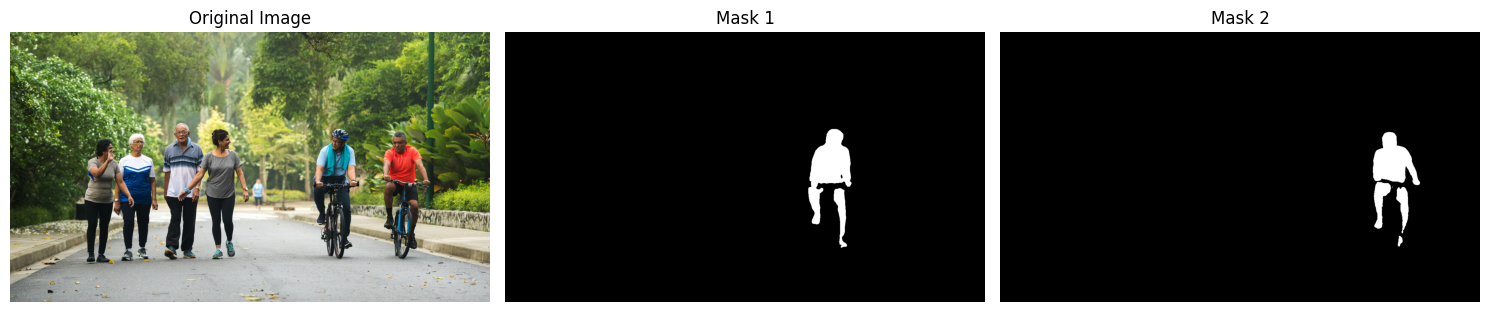

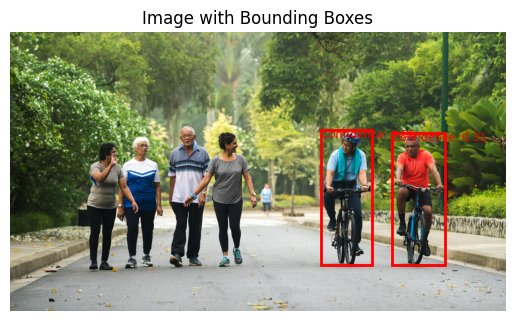

Bounding Boxes:
Box 1: tensor([1003.2976,  314.8559, 1168.4977,  750.3557])
Box 2: tensor([1232.4631,  325.8146, 1403.7943,  751.2402])

Detected Phrases:
Phrase 1: person
Phrase 2: person

Confidence:
Logit 1: 0.5514845252037048
Logit 2: 0.30534663796424866


In [1]:
import warnings
import numpy as np
import matplotlib.pyplot as plt
import requests
from PIL import Image
from io import BytesIO
from lang_sam import LangSAM

image = "https://static01.nyt.com/images/2020/09/08/well/physed-cycle-walk/physed-cycle-walk-videoSixteenByNineJumbo1600-v2.jpg"
# image = "./image.jpg"
text_prompt = "person on a bicycle"

def download_image(url):
    response = requests.get(url)
    response.raise_for_status()
    return Image.open(BytesIO(response.content)).convert("RGB")

def save_mask(mask_np, filename):
    mask_image = Image.fromarray((mask_np * 255).astype(np.uint8))
    mask_image.save(filename)

def display_image_with_masks(image, masks):
    num_masks = len(masks)

    fig, axes = plt.subplots(1, num_masks + 1, figsize=(15, 5))
    axes[0].imshow(image)
    axes[0].set_title("Original Image")
    axes[0].axis('off')

    for i, mask_np in enumerate(masks):
        axes[i+1].imshow(mask_np, cmap='gray')
        axes[i+1].set_title(f"Mask {i+1}")
        axes[i+1].axis('off')

    plt.tight_layout()
    plt.show()

def display_image_with_boxes(image, boxes, logits):
    fig, ax = plt.subplots()
    ax.imshow(image)
    ax.set_title("Image with Bounding Boxes")
    ax.axis('off')

    for box, logit in zip(boxes, logits):
        x_min, y_min, x_max, y_max = box
        confidence_score = round(logit.item(), 2)  # Convert logit to a scalar before rounding
        box_width = x_max - x_min
        box_height = y_max - y_min

        # Draw bounding box
        rect = plt.Rectangle((x_min, y_min), box_width, box_height, fill=False, edgecolor='red', linewidth=2)
        ax.add_patch(rect)

        # Add confidence score as text
        ax.text(x_min, y_min, f"Confidence: {confidence_score}", fontsize=8, color='red', verticalalignment='top')

    plt.show()

def print_bounding_boxes(boxes):
    print("Bounding Boxes:")
    for i, box in enumerate(boxes):
        print(f"Box {i+1}: {box}")

def print_detected_phrases(phrases):
    print("\nDetected Phrases:")
    for i, phrase in enumerate(phrases):
        print(f"Phrase {i+1}: {phrase}")

def print_logits(logits):
    print("\nConfidence:")
    for i, logit in enumerate(logits):
        print(f"Logit {i+1}: {logit}")

def main():
    # Suppress warning messages
    warnings.filterwarnings("ignore")

    try:
        if image.startswith("http"):
            image_pil = download_image(image)
        else:
            image_pil = Image.open(image).convert("RGB")

        model = LangSAM()
        masks, boxes, phrases, logits = model.predict(image_pil, text_prompt)

        if len(masks) == 0:
            print(f"No objects of the '{text_prompt}' prompt detected in the image.")
        else:
            # Convert masks to numpy arrays
            masks_np = [mask.squeeze().cpu().numpy() for mask in masks]

            # Display the original image and masks side by side
            display_image_with_masks(image_pil, masks_np)

            # Display the image with bounding boxes and confidence scores
            display_image_with_boxes(image_pil, boxes, logits)

            # Save the masks
            for i, mask_np in enumerate(masks_np):
                mask_path = f"image_mask_{i+1}.png"
                save_mask(mask_np, mask_path)

            # Print the bounding boxes, phrases, and logits
            print_bounding_boxes(boxes)
            print_detected_phrases(phrases)
            print_logits(logits)

    except (requests.exceptions.RequestException, IOError) as e:
        print(f"Error: {e}")

if __name__ == "__main__":
    main()


In [2]:
import os
import torch
from tqdm import tqdm

def data_transform(data):
    data = data - np.min(data)
    data = np.round(data * 255/np.max(data))
    data = data.astype(np.uint8)
    return np.array(data)

def train_patches(directory):
    transformed_data_list = []
    targets = []
    non_targets = []
    density = []
    transformed_data_list_eval = []
    targets_eval = []
    non_targets_eval = []
    density_eval = []
    
    # Initialize lists to store filenames
    train_filenames = []
    val_filenames = []

    print('Retrieving training data:')
    for i in tqdm(range(10)):  # Range from 0 to 3565 for train samples
        filename = f"train_{i}.pt"
        train_filenames.append(filename)
        file_path = os.path.join(directory, filename)
        if os.path.exists(file_path):
            try:
                data0 = torch.load(file_path)
                data1 = data0['aerial_20'].numpy()
                data1 = data1.transpose()
                transformed_data = data_transform(data1)
                transformed_data_list.append(transformed_data)
                
                target1 = data0['target'].numpy()
                targets.append(target1)
                
                nontargets1 = data0['target_mask'].numpy() - target1
                non_targets.append(nontargets1)

                density1 = data0['density'].numpy()
                density.append(density1)
            except Exception as e:
                print(f"Error processing {filename}: {str(e)}")
    
    print('Retrieving validation data:')
    for i in tqdm(range(5)):  # Range from 0 to 787 for val samples
        filename = f"val_{i}.pt"
        val_filenames.append(filename)
        file_path = os.path.join(directory, filename)
        if os.path.exists(file_path):
            try:
                data0 = torch.load(file_path)
                data1 = data0['aerial_20'].numpy()
                data1 = data1.transpose()
                transformed_data = data_transform(data1)
                transformed_data_list_eval.append(transformed_data)
                
                target1 = data0['target'].numpy()
                targets_eval.append(target1)
                
                nontargets1 = data0['target_mask'].numpy() - target1
                non_targets_eval.append(nontargets1)

                density1 = data0['density'].numpy()
                density_eval.append(density1)
            except Exception as e:
                print(f"Error processing {filename}: {str(e)}")
    
    # Return the filenames along with the data
    return (transformed_data_list, targets, non_targets, density, 
            transformed_data_list_eval, targets_eval, non_targets_eval, density_eval)

data, targets, non_targets, density, data_eval, targets_eval, non_targets_eval, density_eval = train_patches('patches')

print('Total train patches retrived:',len(data))
print('Total evaluation patches retrived:',len(data_eval))

Retrieving training data:


100%|██████████| 10/10 [00:01<00:00,  8.82it/s]


Retrieving validation data:


100%|██████████| 5/5 [00:00<00:00, 121.96it/s]

Total train patches retrived: 10
Total evaluation patches retrived: 5


final text_encoder_type: bert-base-uncased
Model loaded from C:\Users\Daniel Klaaby\.cache\huggingface\hub\models--ShilongLiu--GroundingDINO\snapshots\a94c9b567a2a374598f05c584e96798a170c56fb\groundingdino_swinb_cogcoor.pth 
 => _IncompatibleKeys(missing_keys=[], unexpected_keys=['label_enc.weight', 'bert.embeddings.position_ids'])
No objects of the 'trees' prompt detected in the image.
final text_encoder_type: bert-base-uncased
Model loaded from C:\Users\Daniel Klaaby\.cache\huggingface\hub\models--ShilongLiu--GroundingDINO\snapshots\a94c9b567a2a374598f05c584e96798a170c56fb\groundingdino_swinb_cogcoor.pth 
 => _IncompatibleKeys(missing_keys=[], unexpected_keys=['label_enc.weight', 'bert.embeddings.position_ids'])


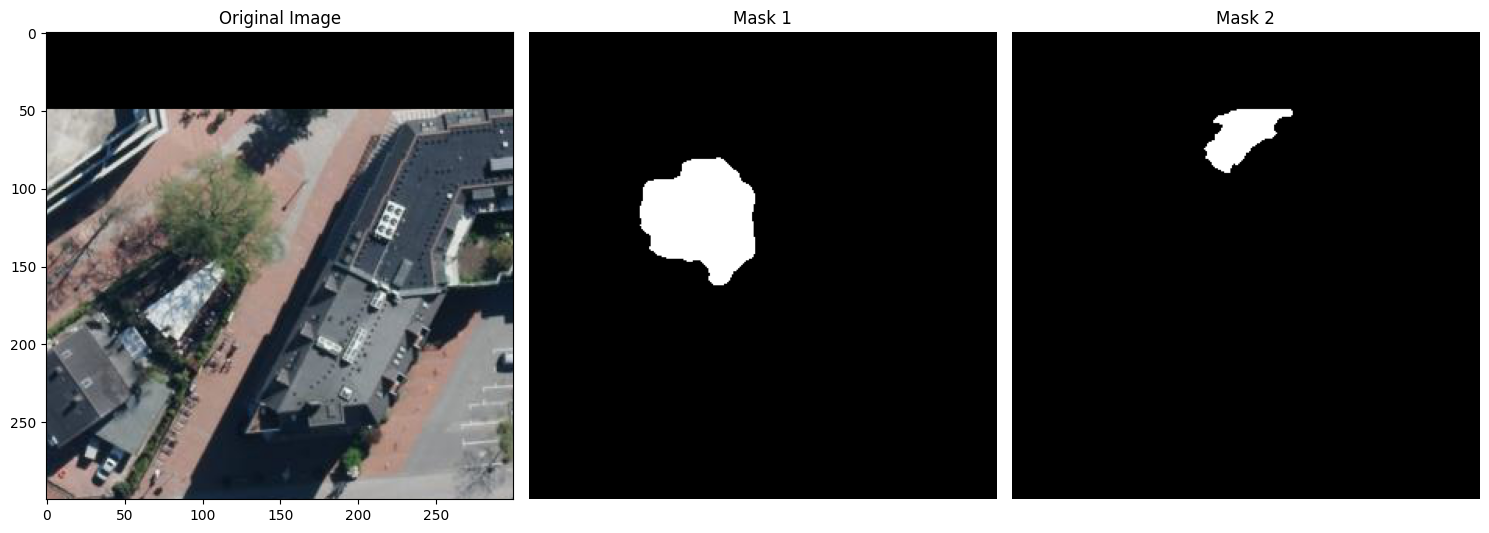

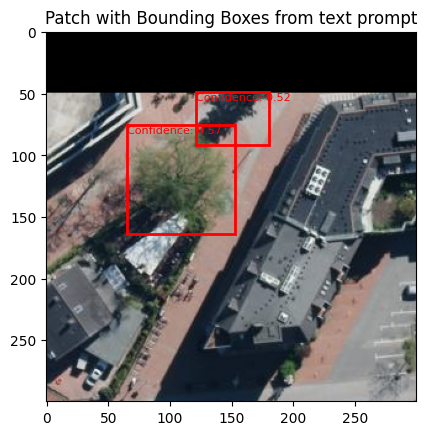

Bounding Boxes:
Box 1: tensor([ 65.1921,  75.2255, 153.1789, 163.7426])
Box 2: tensor([121.3207,  48.7884, 180.7023,  91.8185])

Detected Phrases:
Phrase 1: trees
Phrase 2: trees

Confidence:
Logit 1: 0.56836998462677
Logit 2: 0.5215138792991638
final text_encoder_type: bert-base-uncased
Model loaded from C:\Users\Daniel Klaaby\.cache\huggingface\hub\models--ShilongLiu--GroundingDINO\snapshots\a94c9b567a2a374598f05c584e96798a170c56fb\groundingdino_swinb_cogcoor.pth 
 => _IncompatibleKeys(missing_keys=[], unexpected_keys=['label_enc.weight', 'bert.embeddings.position_ids'])


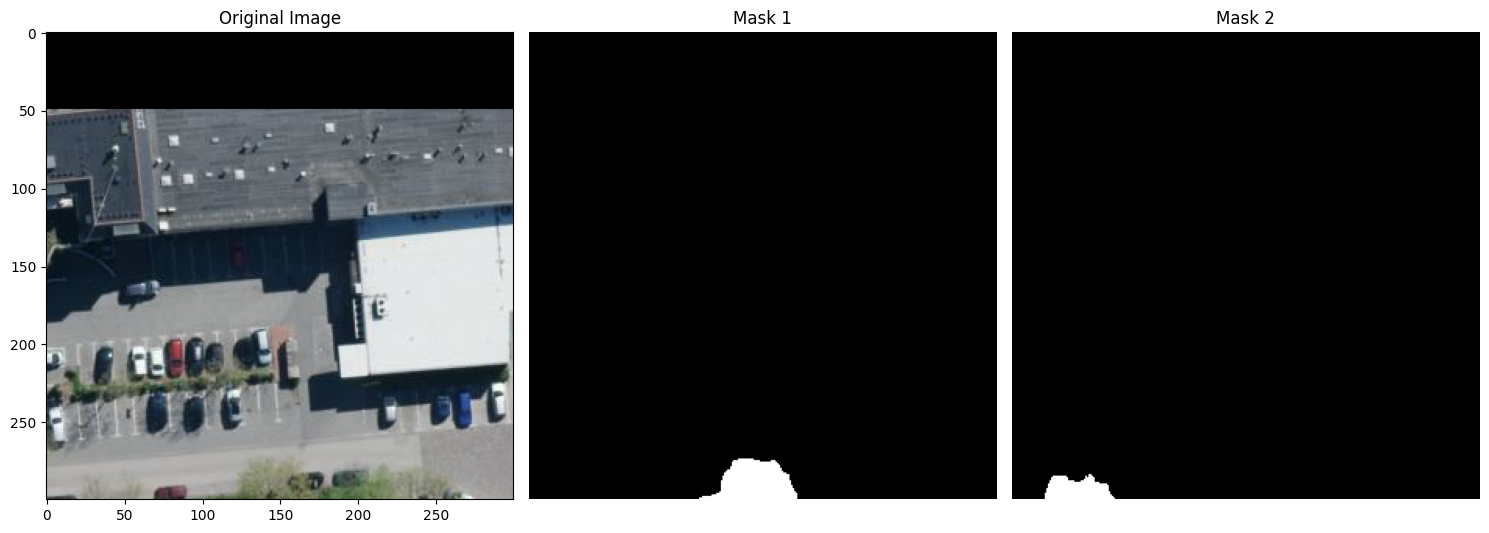

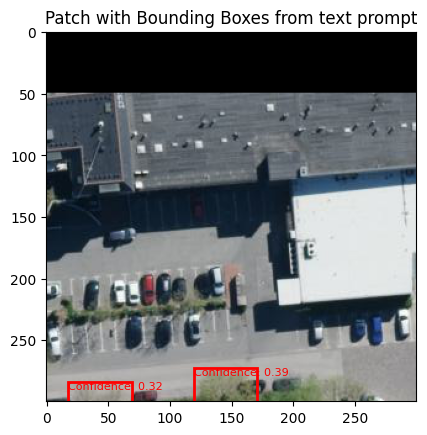

Bounding Boxes:
Box 1: tensor([119.4000, 272.2871, 170.6458, 300.0059])
Box 2: tensor([ 17.3171, 283.4862,  69.1261, 300.0445])

Detected Phrases:
Phrase 1: trees
Phrase 2: trees

Confidence:
Logit 1: 0.38921454548835754
Logit 2: 0.31912484765052795
final text_encoder_type: bert-base-uncased
Model loaded from C:\Users\Daniel Klaaby\.cache\huggingface\hub\models--ShilongLiu--GroundingDINO\snapshots\a94c9b567a2a374598f05c584e96798a170c56fb\groundingdino_swinb_cogcoor.pth 
 => _IncompatibleKeys(missing_keys=[], unexpected_keys=['label_enc.weight', 'bert.embeddings.position_ids'])


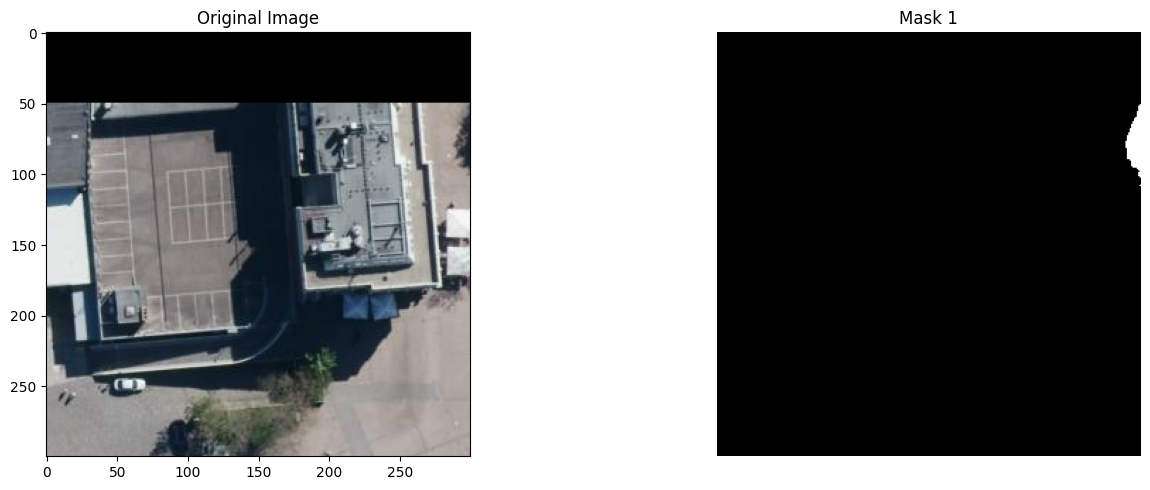

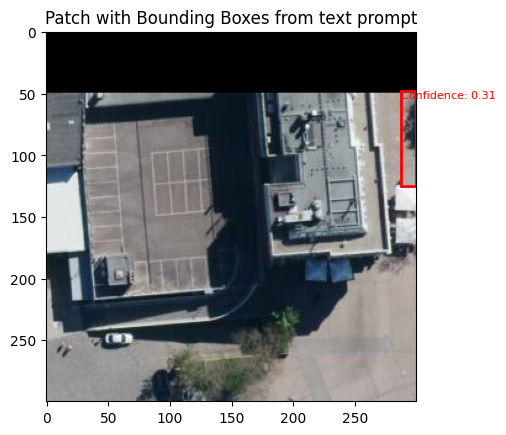

Bounding Boxes:
Box 1: tensor([287.9372,  47.2711, 300.0190, 124.7161])

Detected Phrases:
Phrase 1: trees

Confidence:
Logit 1: 0.30929192900657654
final text_encoder_type: bert-base-uncased
Model loaded from C:\Users\Daniel Klaaby\.cache\huggingface\hub\models--ShilongLiu--GroundingDINO\snapshots\a94c9b567a2a374598f05c584e96798a170c56fb\groundingdino_swinb_cogcoor.pth 
 => _IncompatibleKeys(missing_keys=[], unexpected_keys=['label_enc.weight', 'bert.embeddings.position_ids'])


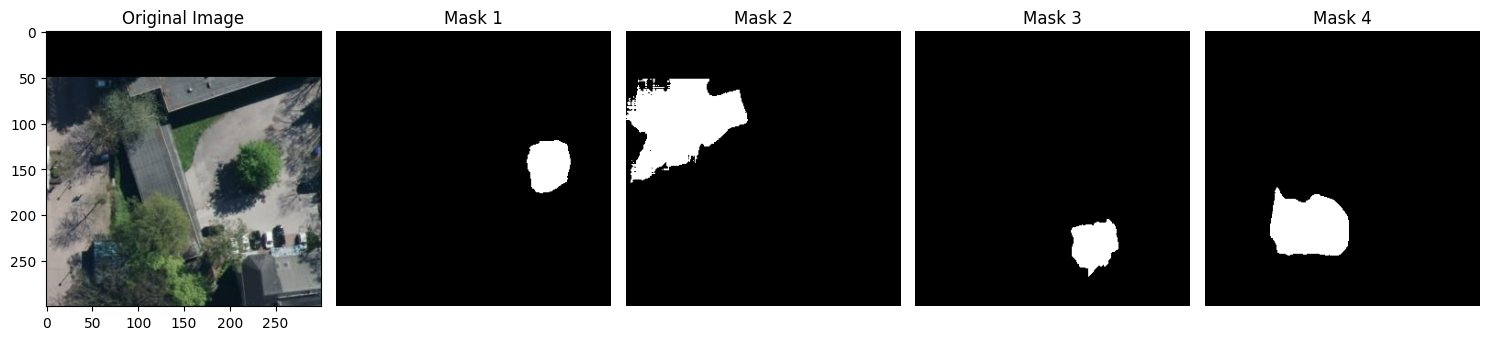

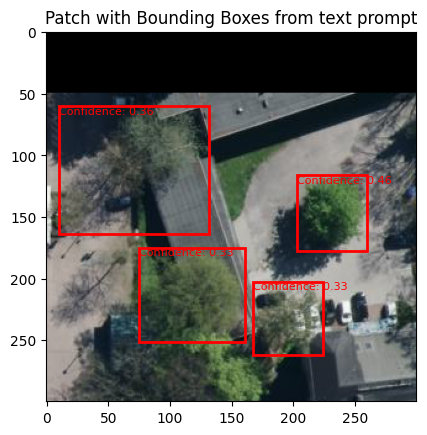

Bounding Boxes:
Box 1: tensor([203.4263, 116.1782, 260.1312, 177.6819])
Box 2: tensor([ 10.1220,  59.8741, 131.5586, 164.1167])
Box 3: tensor([167.0844, 202.2809, 224.6134, 261.6724])
Box 4: tensor([ 74.5820, 174.7489, 160.6598, 251.3992])

Detected Phrases:
Phrase 1: trees
Phrase 2: trees
Phrase 3: trees
Phrase 4: trees

Confidence:
Logit 1: 0.4624386727809906
Logit 2: 0.3566056787967682
Logit 3: 0.3337424695491791
Logit 4: 0.32569336891174316
final text_encoder_type: bert-base-uncased
Model loaded from C:\Users\Daniel Klaaby\.cache\huggingface\hub\models--ShilongLiu--GroundingDINO\snapshots\a94c9b567a2a374598f05c584e96798a170c56fb\groundingdino_swinb_cogcoor.pth 
 => _IncompatibleKeys(missing_keys=[], unexpected_keys=['label_enc.weight', 'bert.embeddings.position_ids'])


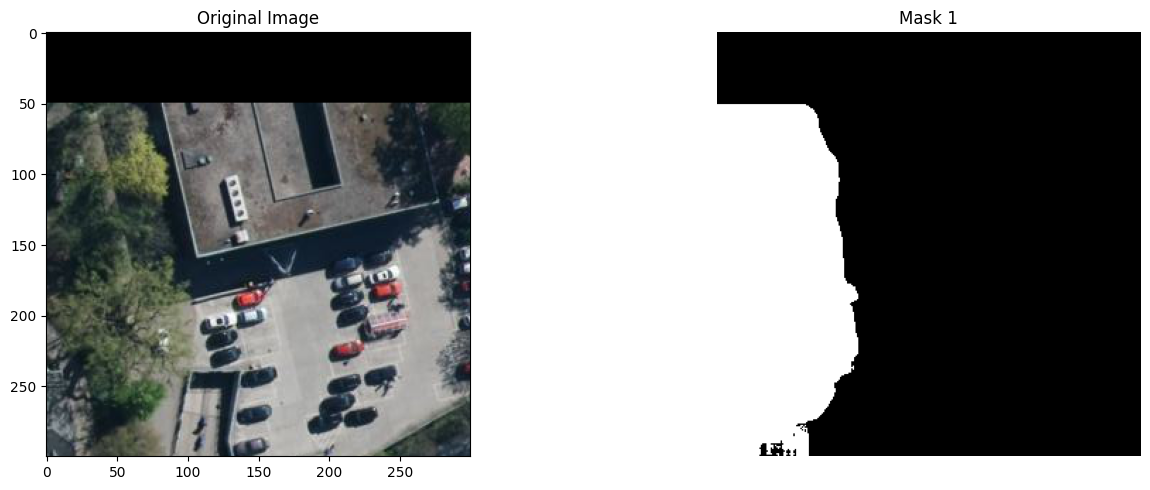

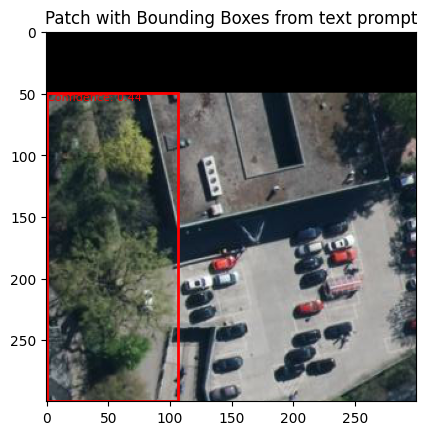

Bounding Boxes:
Box 1: tensor([-3.7466e-02,  4.8974e+01,  1.0693e+02,  2.9957e+02])

Detected Phrases:
Phrase 1: trees

Confidence:
Logit 1: 0.4424377977848053
final text_encoder_type: bert-base-uncased
Model loaded from C:\Users\Daniel Klaaby\.cache\huggingface\hub\models--ShilongLiu--GroundingDINO\snapshots\a94c9b567a2a374598f05c584e96798a170c56fb\groundingdino_swinb_cogcoor.pth 
 => _IncompatibleKeys(missing_keys=[], unexpected_keys=['label_enc.weight', 'bert.embeddings.position_ids'])


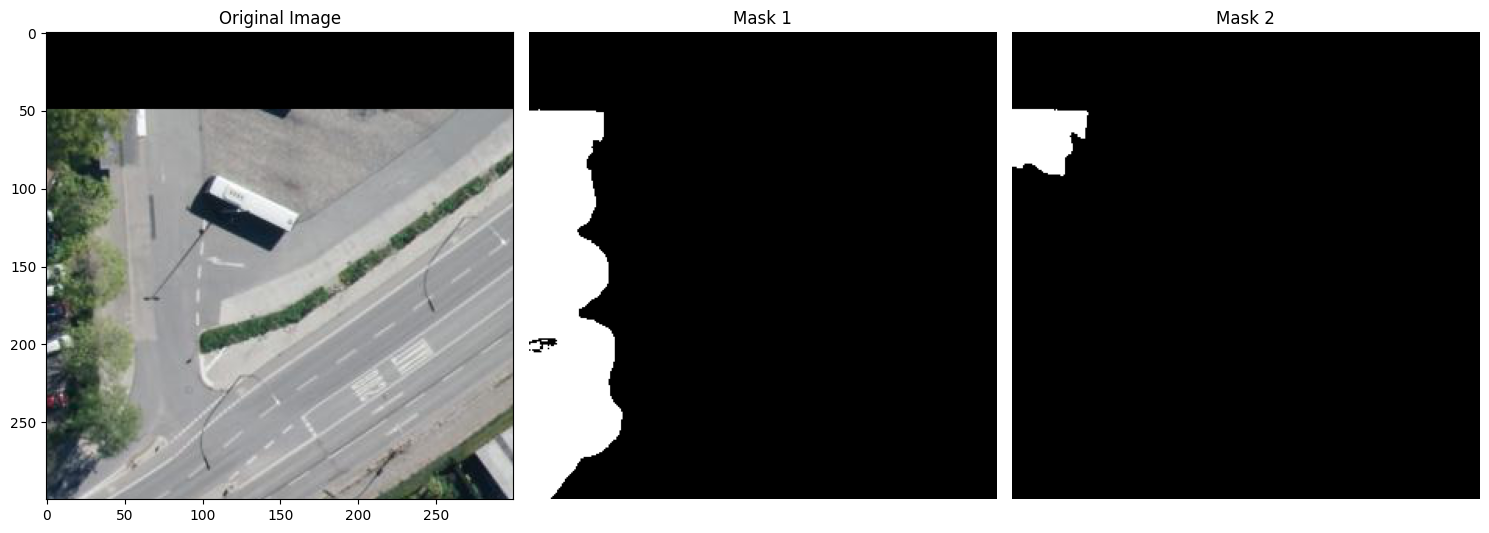

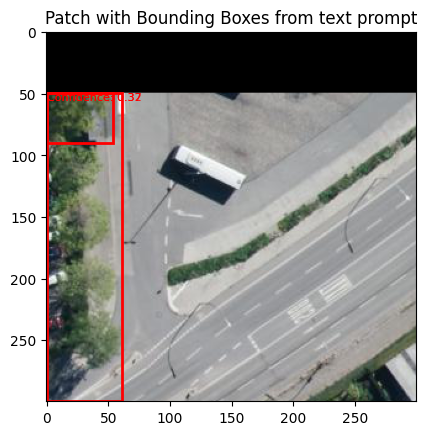

Bounding Boxes:
Box 1: tensor([-5.6284e-02,  4.8941e+01,  6.0848e+01,  2.9950e+02])
Box 2: tensor([-1.2428e-03,  4.8955e+01,  5.3479e+01,  8.9646e+01])

Detected Phrases:
Phrase 1: trees
Phrase 2: trees

Confidence:
Logit 1: 0.3742205500602722
Logit 2: 0.318820595741272
final text_encoder_type: bert-base-uncased
Model loaded from C:\Users\Daniel Klaaby\.cache\huggingface\hub\models--ShilongLiu--GroundingDINO\snapshots\a94c9b567a2a374598f05c584e96798a170c56fb\groundingdino_swinb_cogcoor.pth 
 => _IncompatibleKeys(missing_keys=[], unexpected_keys=['label_enc.weight', 'bert.embeddings.position_ids'])


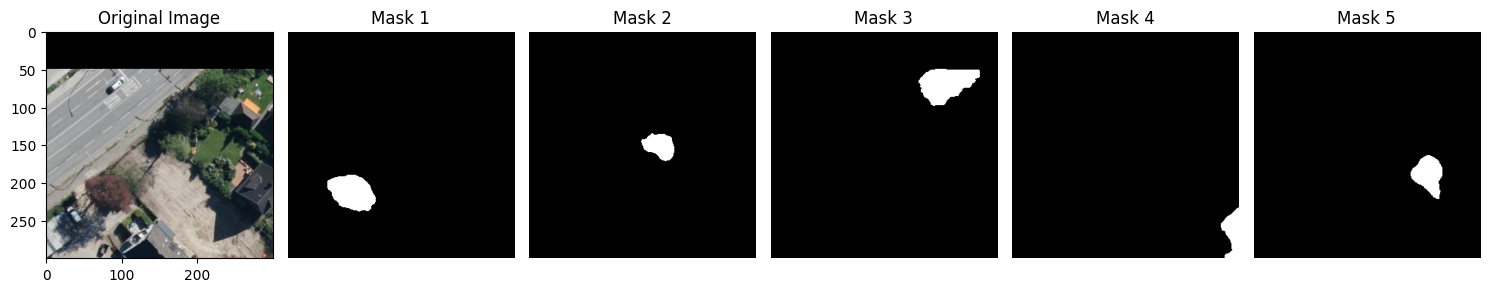

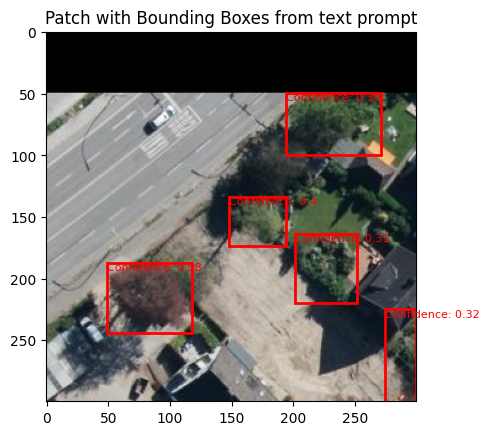

Bounding Boxes:
Box 1: tensor([ 48.6037, 187.1230, 118.1145, 243.8736])
Box 2: tensor([147.8836, 133.5137, 194.1469, 173.3486])
Box 3: tensor([194.2674,  48.9441, 271.2083,  99.3756])
Box 4: tensor([274.6676, 224.8604, 300.0213, 299.7509])
Box 5: tensor([201.8056, 163.3266, 251.9498, 220.0471])

Detected Phrases:
Phrase 1: trees
Phrase 2: trees
Phrase 3: trees
Phrase 4: trees
Phrase 5: trees

Confidence:
Logit 1: 0.5822733044624329
Logit 2: 0.4038386046886444
Logit 3: 0.33833473920822144
Logit 4: 0.31662046909332275
Logit 5: 0.313602089881897
final text_encoder_type: bert-base-uncased
Model loaded from C:\Users\Daniel Klaaby\.cache\huggingface\hub\models--ShilongLiu--GroundingDINO\snapshots\a94c9b567a2a374598f05c584e96798a170c56fb\groundingdino_swinb_cogcoor.pth 
 => _IncompatibleKeys(missing_keys=[], unexpected_keys=['label_enc.weight', 'bert.embeddings.position_ids'])


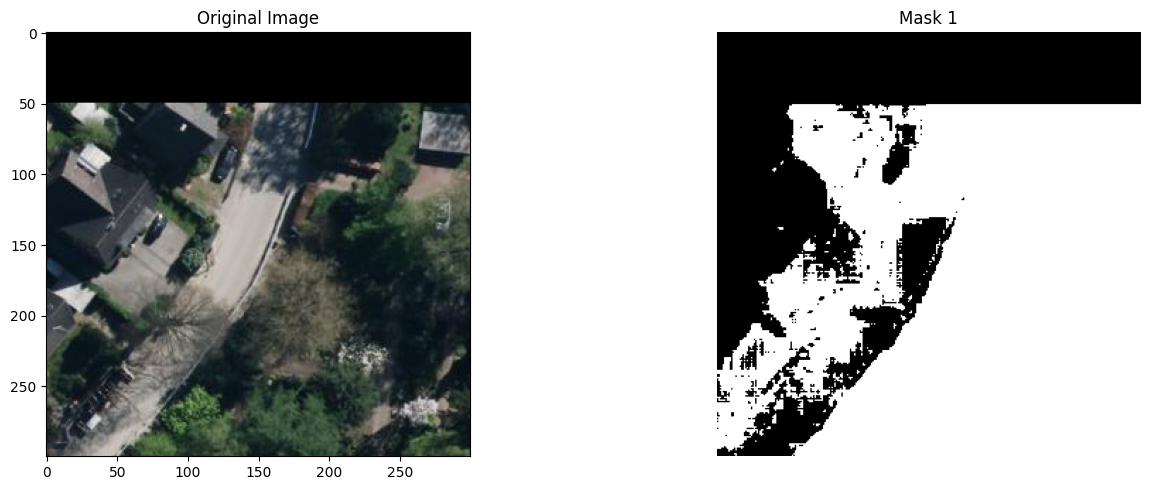

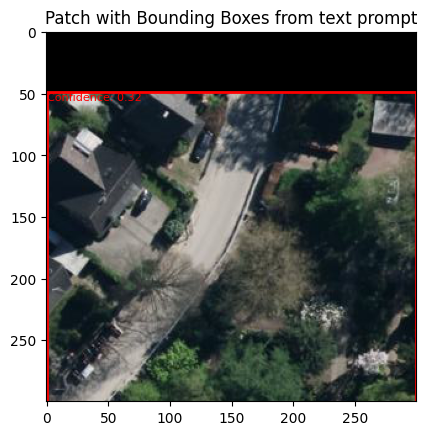

Bounding Boxes:
Box 1: tensor([4.8494e-02, 4.8813e+01, 3.0005e+02, 2.9980e+02])

Detected Phrases:
Phrase 1: trees

Confidence:
Logit 1: 0.31696951389312744
final text_encoder_type: bert-base-uncased
Model loaded from C:\Users\Daniel Klaaby\.cache\huggingface\hub\models--ShilongLiu--GroundingDINO\snapshots\a94c9b567a2a374598f05c584e96798a170c56fb\groundingdino_swinb_cogcoor.pth 
 => _IncompatibleKeys(missing_keys=[], unexpected_keys=['label_enc.weight', 'bert.embeddings.position_ids'])


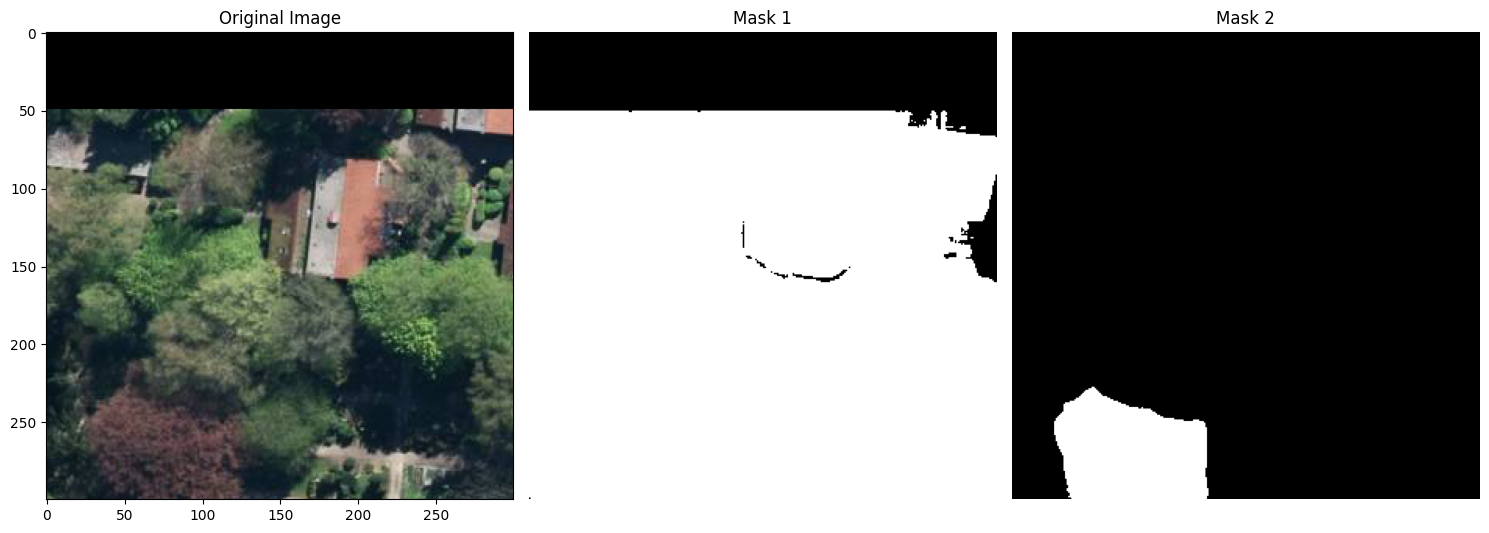

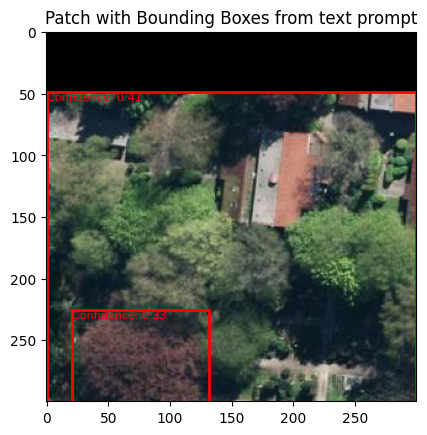

Bounding Boxes:
Box 1: tensor([-1.6558e-02,  4.8610e+01,  2.9998e+02,  2.9991e+02])
Box 2: tensor([ 20.8454, 225.3689, 131.3850, 300.0122])

Detected Phrases:
Phrase 1: trees
Phrase 2: trees

Confidence:
Logit 1: 0.40640634298324585
Logit 2: 0.3289068639278412


In [9]:
import warnings
import numpy as np
import matplotlib.pyplot as plt
import requests
from PIL import Image
from io import BytesIO
from lang_sam import LangSAM

image = data[2]
# image = "./image.jpg"
text_prompt = "trees"

def download_image(url):
    response = requests.get(url)
    response.raise_for_status()
    return Image.open(BytesIO(response.content)).convert("RGB")

def save_mask(mask_np, filename):
    mask_image = Image.fromarray((mask_np * 255).astype(np.uint8))
    mask_image.save(filename)

def display_image_with_masks(image, masks):
    num_masks = len(masks)

    fig, axes = plt.subplots(1, num_masks + 1, figsize=(15, 5))
    axes[0].imshow(image)
    axes[0].set_title("Original Image")
    #axes[0].axis('off')

    for i, mask_np in enumerate(masks):
        axes[i+1].imshow(mask_np, cmap='gray')
        axes[i+1].set_title(f"Mask {i+1}")
        axes[i+1].axis('off')

    plt.tight_layout()
    plt.show()

def display_image_with_boxes(image, boxes, logits):
    fig, ax = plt.subplots()
    ax.imshow(image)
    ax.set_title("Patch with Bounding Boxes from text prompt")
    #ax.axis('off')

    for box, logit in zip(boxes, logits):
        x_min, y_min, x_max, y_max = box
        confidence_score = round(logit.item(), 2)  # Convert logit to a scalar before rounding
        box_width = x_max - x_min
        box_height = y_max - y_min

        # Draw bounding box
        rect = plt.Rectangle((x_min, y_min), box_width, box_height, fill=False, edgecolor='red', linewidth=2)
        ax.add_patch(rect)

        # Add confidence score as text
        ax.text(x_min, y_min, f"Confidence: {confidence_score}", fontsize=8, color='red', verticalalignment='top')

    plt.show()

def print_bounding_boxes(boxes):
    print("Bounding Boxes:")
    for i, box in enumerate(boxes):
        print(f"Box {i+1}: {box}")

def print_detected_phrases(phrases):
    print("\nDetected Phrases:")
    for i, phrase in enumerate(phrases):
        print(f"Phrase {i+1}: {phrase}")

def print_logits(logits):
    print("\nConfidence:")
    for i, logit in enumerate(logits):
        print(f"Logit {i+1}: {logit}")

def main():
    # Suppress warning messages
    warnings.filterwarnings("ignore")
    for i in range(len(data)):
        image=data[i]
        try:
            image_pil = Image.fromarray(image)

            model = LangSAM()
            masks, boxes, phrases, logits = model.predict(image_pil, text_prompt)

            if len(masks) == 0:
                print(f"No objects of the '{text_prompt}' prompt detected in the image.")
            else:
                # Convert masks to numpy arrays
                masks_np = [mask.squeeze().cpu().numpy() for mask in masks]

                # Display the original image and masks side by side
                display_image_with_masks(image_pil, masks_np)

                # Display the image with bounding boxes and confidence scores
                display_image_with_boxes(image_pil, boxes, logits)

                # Save the masks
                #for i, mask_np in enumerate(masks_np):
                    #mask_path = f"image_mask_{i+1}.png"
                    #save_mask(mask_np, mask_path)

                # Print the bounding boxes, phrases, and logits
                print_bounding_boxes(boxes)
                print_detected_phrases(phrases)
                print_logits(logits)

        except (requests.exceptions.RequestException, IOError) as e:
            print(f"Error: {e}")

if __name__ == "__main__":
    main()


In [46]:
image=data[2]

def print_bounding_boxes(boxes):
    print("Bounding Boxes:")
    for i, box in enumerate(boxes):
        print(f"Box {i+1}: {box}")

text_prompt = "trees"

def killl():
    # Suppress warning messages
    warnings.filterwarnings("ignore")

    # List to store boxes for each image
    boxes_list = []

    for i in range(len(data[0:2])):
        image = data[i]
        try:
            image_pil = Image.fromarray(image)

            model = LangSAM()
            masks, boxes, _, _ = model.predict(image_pil, text_prompt)
            print(boxes)

            if len(masks) == 0:
                print(f"No objects of the '{text_prompt}' prompt detected in the image.")
                # Append an empty box tensor if no masks are detected
                empty_box_tensor = torch.tensor([[0, 0, 0, 0]], dtype=torch.float32)
                boxes_list.append(empty_box_tensor)
            else:
                # Convert boxes to a tensor if they are not already
                boxes_tensor = torch.tensor(boxes, dtype=torch.float32)
                # Save the boxes for this image
                boxes_list.append(boxes_tensor)

        except (requests.exceptions.RequestException, IOError) as e:
            print(f"Error: {e}")

    # Save the list of tensors to a file
    torch.save(boxes_list, 'boxes_list.pt')

    # Now boxes_list contains the boxes tensors for each image
    return boxes_list

 
lisst = killl()

final text_encoder_type: bert-base-uncased
Model loaded from C:\Users\Daniel Klaaby\.cache\huggingface\hub\models--ShilongLiu--GroundingDINO\snapshots\a94c9b567a2a374598f05c584e96798a170c56fb\groundingdino_swinb_cogcoor.pth 
 => _IncompatibleKeys(missing_keys=[], unexpected_keys=['label_enc.weight', 'bert.embeddings.position_ids'])
tensor([], size=(0, 4))
No objects of the 'trees' prompt detected in the image.
final text_encoder_type: bert-base-uncased
Model loaded from C:\Users\Daniel Klaaby\.cache\huggingface\hub\models--ShilongLiu--GroundingDINO\snapshots\a94c9b567a2a374598f05c584e96798a170c56fb\groundingdino_swinb_cogcoor.pth 
 => _IncompatibleKeys(missing_keys=[], unexpected_keys=['label_enc.weight', 'bert.embeddings.position_ids'])
tensor([[ 65.1921,  75.2255, 153.1789, 163.7426],
        [121.3207,  48.7884, 180.7023,  91.8185]])


In [50]:
loaded_boxes_list = torch.load('boxes_list.pt')
loaded_boxes_list[1]

tensor([[ 65.1921,  75.2255, 153.1789, 163.7426],
        [121.3207,  48.7884, 180.7023,  91.8185]])

final text_encoder_type: bert-base-uncased
Model loaded from C:\Users\Daniel Klaaby\.cache\huggingface\hub\models--ShilongLiu--GroundingDINO\snapshots\a94c9b567a2a374598f05c584e96798a170c56fb\groundingdino_swinb_cogcoor.pth 
 => _IncompatibleKeys(missing_keys=[], unexpected_keys=['label_enc.weight', 'bert.embeddings.position_ids'])


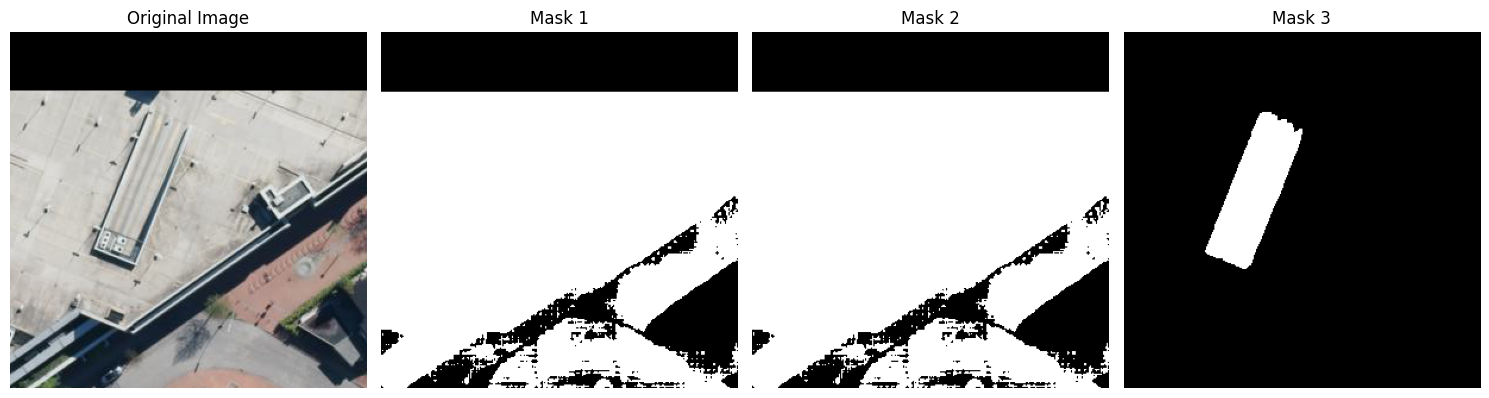

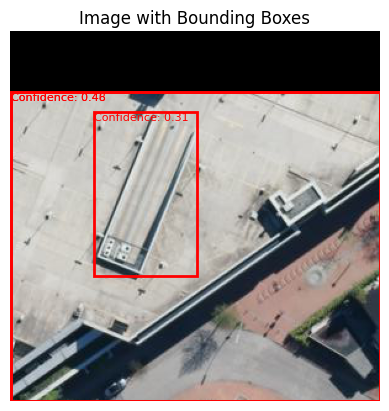

Bounding Boxes:
Box 1: tensor([2.5392e-03, 4.8846e+01, 3.0000e+02, 2.9949e+02])
Box 2: tensor([-3.1650e-03,  4.8698e+01,  3.0000e+02,  2.9976e+02])
Box 3: tensor([ 67.6939,  64.5845, 151.5806, 198.1998])

Detected Phrases:
Phrase 1: road
Phrase 2: ##lding pitch stadium field
Phrase 3: road

Confidence:
Logit 1: 0.4812455177307129
Logit 2: 0.45729535818099976
Logit 3: 0.30861756205558777
final text_encoder_type: bert-base-uncased
Model loaded from C:\Users\Daniel Klaaby\.cache\huggingface\hub\models--ShilongLiu--GroundingDINO\snapshots\a94c9b567a2a374598f05c584e96798a170c56fb\groundingdino_swinb_cogcoor.pth 
 => _IncompatibleKeys(missing_keys=[], unexpected_keys=['label_enc.weight', 'bert.embeddings.position_ids'])


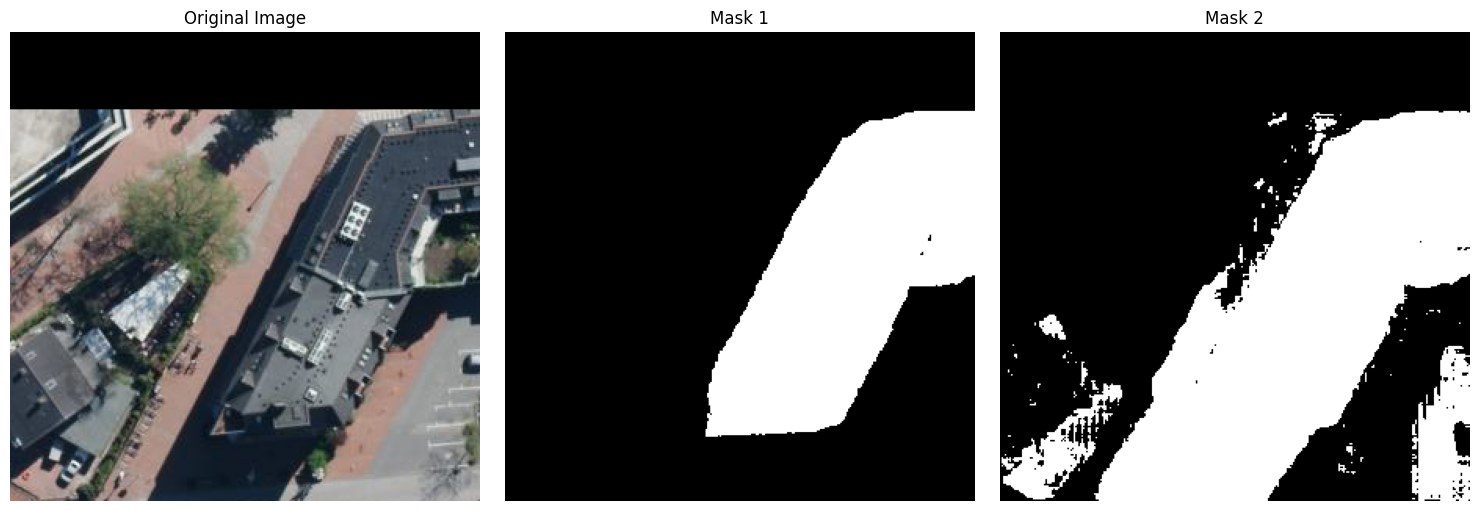

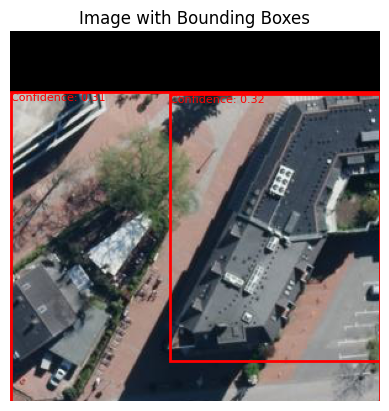

Bounding Boxes:
Box 1: tensor([129.4609,  50.3104, 299.9746, 266.6702])
Box 2: tensor([1.8686e-02, 4.8720e+01, 3.0002e+02, 2.9992e+02])

Detected Phrases:
Phrase 1: road
Phrase 2: road

Confidence:
Logit 1: 0.3219272196292877
Logit 2: 0.3086724877357483
final text_encoder_type: bert-base-uncased
Model loaded from C:\Users\Daniel Klaaby\.cache\huggingface\hub\models--ShilongLiu--GroundingDINO\snapshots\a94c9b567a2a374598f05c584e96798a170c56fb\groundingdino_swinb_cogcoor.pth 
 => _IncompatibleKeys(missing_keys=[], unexpected_keys=['label_enc.weight', 'bert.embeddings.position_ids'])


KeyboardInterrupt: 

In [4]:
import warnings
import numpy as np
import matplotlib.pyplot as plt
import requests
from PIL import Image
from io import BytesIO
from lang_sam import LangSAM

image = data[2]
# image = "./image.jpg"
text_prompt = "road bulding "

def download_image(url):
    response = requests.get(url)
    response.raise_for_status()
    return Image.open(BytesIO(response.content)).convert("RGB")

def save_mask(mask_np, filename):
    mask_image = Image.fromarray((mask_np * 255).astype(np.uint8))
    mask_image.save(filename)

def display_image_with_masks(image, masks):
    num_masks = len(masks)

    fig, axes = plt.subplots(1, num_masks + 1, figsize=(15, 5))
    axes[0].imshow(image)
    axes[0].set_title("Original Image")
    #axes[0].axis('off')

    for i, mask_np in enumerate(masks):
        axes[i+1].imshow(mask_np, cmap='gray')
        axes[i+1].set_title(f"Mask {i+1}")
        axes[i+1].axis('off')

    plt.tight_layout()
    plt.show()

def display_image_with_boxes(image, boxes, logits):
    fig, ax = plt.subplots()
    ax.imshow(image)
    ax.set_title("Image with Bounding Boxes")
    #ax.axis('off')

    for box, logit in zip(boxes, logits):
        x_min, y_min, x_max, y_max = box
        confidence_score = round(logit.item(), 2)  # Convert logit to a scalar before rounding
        box_width = x_max - x_min
        box_height = y_max - y_min

        # Draw bounding box
        rect = plt.Rectangle((x_min, y_min), box_width, box_height, fill=False, edgecolor='red', linewidth=2)
        ax.add_patch(rect)

        # Add confidence score as text
        ax.text(x_min, y_min, f"Confidence: {confidence_score}", fontsize=8, color='red', verticalalignment='top')

    plt.show()

def print_bounding_boxes(boxes):
    print("Bounding Boxes:")
    for i, box in enumerate(boxes):
        print(f"Box {i+1}: {box}")

def print_detected_phrases(phrases):
    print("\nDetected Phrases:")
    for i, phrase in enumerate(phrases):
        print(f"Phrase {i+1}: {phrase}")

def print_logits(logits):
    print("\nConfidence:")
    for i, logit in enumerate(logits):
        print(f"Logit {i+1}: {logit}")

def main():
    # Suppress warning messages
    warnings.filterwarnings("ignore")
    for i in range(len(data)):
        image=data[i]
        try:
            image_pil = Image.fromarray(image)

            model = LangSAM()
            masks, boxes, phrases, logits = model.predict(image_pil, text_prompt)

            if len(masks) == 0:
                print(f"No objects of the '{text_prompt}' prompt detected in the image.")
            else:
                # Convert masks to numpy arrays
                masks_np = [mask.squeeze().cpu().numpy() for mask in masks]

                # Display the original image and masks side by side
                display_image_with_masks(image_pil, masks_np)

                # Display the image with bounding boxes and confidence scores
                display_image_with_boxes(image_pil, boxes, logits)

                # Save the masks
                for i, mask_np in enumerate(masks_np):
                    mask_path = f"image_mask_{i+1}.png"
                    save_mask(mask_np, mask_path)

                # Print the bounding boxes, phrases, and logits
                print_bounding_boxes(boxes)
                print_detected_phrases(phrases)
                print_logits(logits)

        except (requests.exceptions.RequestException, IOError) as e:
            print(f"Error: {e}")


image = data[2]
# image = "./image.jpg"
text_prompt = "road bulding pitch stadium field "

if __name__ == "__main__":
    main()
